<a href="https://colab.research.google.com/github/Nancy-Shi/Individual_Infection_Network/blob/main/ANU_Residence_real_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Reads the real ANU residence edge list file

2. Creates a directed graph from it

3. Runs the same analysis on the real dataset

4. Saves all outputs with the prefix "0213_217_residence"

5. Generates all the same visualizations and tables for the real data

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

import networkx as nx
import matplotlib.pyplot as plt
import pickle
import numpy as np
import pandas as pd
import os
from joblib import Parallel, delayed
import time

Mounted at /content/drive


In [ ]:
def generate_network_from_edgelist(file_path):
    G = nx.DiGraph()
    with open(file_path, 'r') as f:
        for i, line in enumerate(f):
            line = line.strip()
            if not line or line.startswith('%'):
                continue
            parts = line.split()
            if len(parts) >= 2:
                try:
                    source = int(parts[0])
                    target = int(parts[1])
                    G.add_edge(source, target)
                except ValueError:
                    continue
    return G

In [ ]:
def preprocess_neighbors_fast(G):
    nodes = sorted(G.nodes())
    node_index = {v: i for i, v in enumerate(nodes)}
    neighbors_idx = []
    for v in nodes:
        neighbors_idx.append(np.array([node_index[u] for u in G.neighbors(v)], dtype=int))
    return nodes, node_index, neighbors_idx

In [ ]:
# Optimized solver with early stopping
def fixed_point_solver_message_passing_optimized(neighbors_idx, seed_index, p_val, tol=1e-6, max_iter=1000, relax=0.5):
    n = len(neighbors_idx)

    edge_indices = {}
    for i in range(n):
        for j in neighbors_idx[i]:
            edge_indices[(j, i)] = len(edge_indices)

    m = len(edge_indices)
    theta = np.ones(m, dtype=float)

    for iteration in range(max_iter):
        theta_new = theta.copy()

        for (j, i), e_idx in edge_indices.items():
            if j == seed_index:
                theta_new[e_idx] = 1.0 - p_val
                continue

            neigh_j = neighbors_idx[j]
            if len(neigh_j) == 0:
                u = 1.0
            else:
                prod = 1.0
                for k in neigh_j:
                    if k == i:
                        continue
                    prod *= theta[edge_indices[(k, j)]]
                u = prod

            theta_new[e_idx] = 1.0 - p_val + p_val * u

        # Update with relaxation
        theta = (1.0 - relax) * theta + relax * theta_new

        if iteration % 10 == 0 and iteration > 0:
            if np.max(np.abs(theta - theta_new)) < tol:
                break

    sigma = np.zeros(n, dtype=float)
    for i in range(n):
        if i == seed_index:
            sigma[i] = 1.0
            continue

        neigh_i = neighbors_idx[i]
        if len(neigh_i) == 0:
            sigma[i] = 0.0
            continue

        prod = 1.0
        for j in neigh_i:
            prod *= theta[edge_indices[(j, i)]]
        sigma[i] = 1.0 - prod

    return sigma

In [ ]:
def compute_attack_matrix_optimized(G, p_val, n_jobs=-1, batch_size=10):
    nodes, node_index, neighbors_idx = preprocess_neighbors_fast(G)
    n = len(nodes)

    print(f"Computing attack matrix for {n} nodes with p={p_val}...")
    start_time = time.time()

    sigmas = []
    for i in range(0, n, batch_size):
        batch_end = min(i + batch_size, n)
        batch_nodes = nodes[i:batch_end]

        batch_sigmas = Parallel(n_jobs=n_jobs)(
            delayed(fixed_point_solver_message_passing_optimized)(
                neighbors_idx, seed_index=node_index[s], p_val=p_val
            )
            for s in batch_nodes
        )
        sigmas.extend(batch_sigmas)

        elapsed = time.time() - start_time
        print(f"  Processed {batch_end}/{n} nodes ({batch_end/n*100:.1f}%) in {elapsed:.1f}s")

    mat = np.array(sigmas).T
    print(f"Total time: {time.time() - start_time:.1f}s")

    return nodes, mat

In [ ]:
def save_attack_csv(nodes, mat, p_val, outdir="/content/drive/My Drive/Individual_Attack_Rate"):
    os.makedirs(outdir, exist_ok=True)
    df = pd.DataFrame(
        mat,
        index=[f"sigma_{i}" for i in nodes],
        columns=[f"Seed {i}" for i in nodes]
    )
    path = os.path.join(outdir, f"0213_217_residence_attack_matrix.csv")
    df.to_csv(path, float_format="%.6f")
    return path, df

In [ ]:
def compute_average_attack(nodes, mat):
    mat_no_diag = mat.copy()
    np.fill_diagonal(mat_no_diag, np.nan)
    return np.nanmean(mat_no_diag, axis=1)

def save_average_attack_csv(nodes, avg_attack, p_val, outdir="/content/drive/My Drive/Individual_Attack_Rate"):
    os.makedirs(outdir, exist_ok=True)
    df = pd.DataFrame({
        "Node": nodes,
        "AverageAttackRate": avg_attack
    })
    path = os.path.join(outdir, f"0213_217_residence_average.csv")
    df.to_csv(path, index=False, float_format="%.6f")
    return path, df

In [ ]:
def save_average_attack_csv(nodes, avg_attack, p_val, outdir="/content/drive/My Drive/Individual_Attack_Rate"):
    os.makedirs(outdir, exist_ok=True)
    df = pd.DataFrame({
        "Node": nodes,
        "AverageAttackRate": avg_attack
    })
    path = os.path.join(outdir, f"0213_217_residence_average.csv")
    df.to_csv(path, index=False, float_format="%.6f")
    return path, df

In [ ]:
def visualize_attack_network_scirep(
    G,
    nodes,
    avg_attack,
    cmap_name="jet",
    out_path="/content/drive/My Drive/Individual_Attack_Rate/0213_217_residence_network.pdf",
    seed=42,
    node_size=70,
    label_fontsize=5,
    draw_labels=True
):
    import numpy as np
    import matplotlib.pyplot as plt
    import networkx as nx

    if nx.is_directed(G):
        G_vis = G.to_undirected()
    else:
        G_vis = G.copy()

    nodes = list(nodes)
    avg_attack = np.asarray(avg_attack, dtype=float)
    attack_dict = {node: avg_attack[i] for i, node in enumerate(nodes)}

    n = G_vis.number_of_nodes()

    k = 1.8 / np.sqrt(n)
    pos = nx.spring_layout(
        G_vis,
        seed=seed,
        k=k,
        iterations=1000,
        scale=1.0
    )

    pos_array = np.array(list(pos.values()))
    center = pos_array.mean(axis=0)
    pos_array -= center
    max_range = np.abs(pos_array).max()
    if max_range > 0:
        pos_array /= max_range

    pos = {node: tuple(pos_array[i]) for i, node in enumerate(G_vis.nodes())}

    node_colors = [attack_dict[n] for n in G_vis.nodes()]
    vmin = float(np.nanmin(avg_attack))
    vmax = float(np.nanmax(avg_attack))

    fig, ax = plt.subplots(figsize=(7.2, 6.0))
    ax.set_facecolor("white")

    nx.draw_networkx_edges(
        G_vis,
        pos,
        ax=ax,
        alpha=0.35,
        width=0.8,
        edge_color="gray"
    )

    nodes_draw = nx.draw_networkx_nodes(
        G_vis,
        pos,
        ax=ax,
        node_color=node_colors,
        cmap=plt.get_cmap(cmap_name),
        node_size=node_size,
        linewidths=0.3,
        edgecolors="black",
        vmin=vmin,
        vmax=vmax
    )

    if draw_labels:
        nx.draw_networkx_labels(
            G_vis,
            pos,
            ax=ax,
            font_size=label_fontsize
        )

    cbar = fig.colorbar(
        nodes_draw,
        ax=ax,
        orientation="horizontal",
        fraction=0.05,
        pad=0.08
    )
    cbar.set_label("Average individual infection probability", fontsize=10)
    cbar.ax.tick_params(labelsize=7)

    ax.set_axis_off()
    plt.tight_layout()
    plt.savefig(out_path, dpi=400, bbox_inches="tight")
    plt.show()


In [ ]:
def save_graph_neighbor_csv(G, filename="0213_217_residence_neighbors.csv"):
    outdir = "/content/drive/My Drive/Individual_Attack_Rate"
    os.makedirs(outdir, exist_ok=True)
    path = os.path.join(outdir, filename)
    nodes = sorted(G.nodes())
    index_map = {v: i for i, v in enumerate(nodes)}
    data = []
    for v in nodes:
        neigh_indices = [index_map[u] for u in G.neighbors(v)]
        neigh_str = ",".join(str(n) for n in neigh_indices)
        degree = len(neigh_indices)
        data.append([index_map[v], neigh_str, degree])
    df = pd.DataFrame(data, columns=["node", "neighbors", "degree"])
    df.to_csv(path, index=False)
    return path, df

In [ ]:
def rank_nodes_by_attack(csv_path, outdir="/content/drive/My Drive/Individual_Attack_Rate"):
    df = pd.read_csv(csv_path)
    df_ranked = df.sort_values(by="AverageAttackRate", ascending=False).reset_index(drop=True)
    df_ranked["Rank"] = df_ranked.index + 1
    os.makedirs(outdir, exist_ok=True)
    out_path = os.path.join(outdir, "0213_217_residence_ranked_average.csv")
    df_ranked.to_csv(out_path, index=False, float_format="%.6f")
    print("\nRanked results:\n")
    print(df_ranked.head())
    return out_path, df_ranked

In [ ]:
file_path = '/content/drive/MyDrive/Individual_Attack_Rate/soc-ANU-residence.edges'
df = pd.read_csv(file_path,
                 sep=r'\s+',
                 skiprows=2,
                 names=['source', 'target', 'weight'],
                 comment='%')

G = nx.from_pandas_edgelist(df,
                              source='source',
                              target='target',
                              edge_attr='weight',
                              create_using=nx.DiGraph())

with open("/content/drive/My Drive/Individual_Attack_Rate/0213_217_residence_network.pkl", "wb") as f:
    pickle.dump(G, f)

nodes, mat = compute_attack_matrix_optimized(G, 0.1)
path, df = save_attack_csv(nodes, mat, 0.1)
avg_attack = compute_average_attack(nodes, mat)
path2, df2 = save_average_attack_csv(nodes, avg_attack, 0.1)


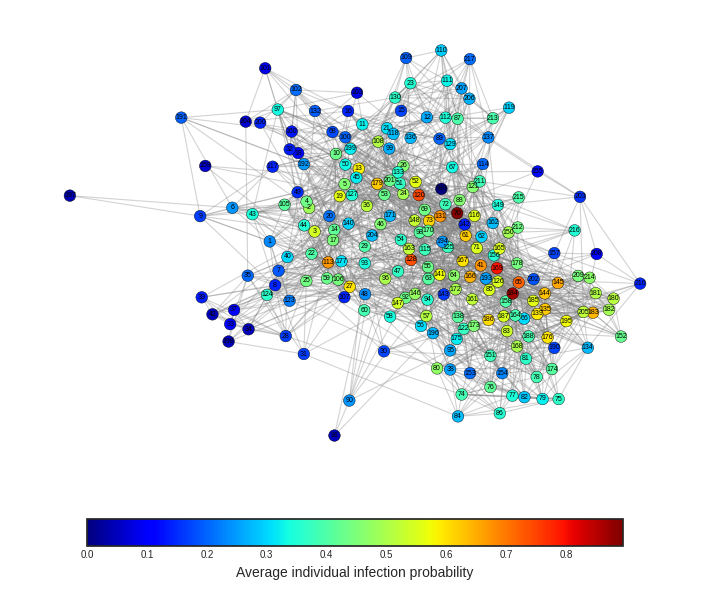

In [ ]:
visualize_attack_network_scirep(G, nodes, avg_attack, out_path="/content/drive/My Drive/Individual_Attack_Rate/0213_217_residence_network.pdf")

In [ ]:
path3, df3 = save_graph_neighbor_csv(G, "0213_217_residence_neighbors.csv")
print("Saved to:", path3)

csv_path = "/content/drive/My Drive/Individual_Attack_Rate/0213_217_residence_average.csv"
out_path, df_ranked = rank_nodes_by_attack(csv_path)
print("Saved ranked file to:", out_path)

Saved to: /content/drive/My Drive/Individual_Attack_Rate/0213_217_residence_neighbors.csv

Ranked results:

   Node  AverageAttackRate  Rank
0    70           0.895047     1
1   184           0.865312     2
2   169           0.795350     3
3   120           0.745563     4
4   128           0.740588     5
Saved ranked file to: /content/drive/My Drive/Individual_Attack_Rate/0213_217_residence_ranked_average.csv


In [ ]:
df = pd.read_csv("/content/drive/My Drive/Individual_Attack_Rate/0213_217_residence_neighbors.csv")
sample = df.sample(5, random_state=14)
latex_table = sample.to_latex(
    index=False,
    column_format="lll",
    caption="Sample rows from the node–neighbor–degree table for ANU residence network.",
    label="tab:sample_neighbors_residence",
    escape=False
)
print(latex_table)

\begin{table}
\caption{Sample rows from the node–neighbor–degree table for ANU residence network.}
\label{tab:sample_neighbors_residence}
\begin{tabular}{lll}
\toprule
node & neighbors & degree \\
\midrule
121 & 26,75,150,151,152,153,29,106,81,37,154,138,53,155 & 14 \\
5 & 0,1,97,48,112,116,8,70 & 8 \\
44 & 66,26,2,158,68,86,126,128,111,23 & 10 \\
171 & 162,137,150,91,169,174,46,185,130,165,166,69,40 & 13 \\
47 & 1,3,55,57,45,192,68 & 7 \\
\bottomrule
\end{tabular}
\end{table}



In [ ]:
ranked_path = "/content/drive/My Drive/Individual_Attack_Rate/0213_217_residence_ranked_average.csv"
df_ranked = pd.read_csv(ranked_path)
top5 = df_ranked.head(5)
bottom5 = df_ranked.tail(5)
top5_latex = top5.to_latex(
    index=False,
    column_format="lll",
    caption="Top 5 nodes with highest average infection probability in ANU residence network.",
    label="tab:top5_attack_residence",
    float_format="%.6f"
)
bottom5_latex = bottom5.to_latex(
    index=False,
    column_format="lll",
    caption="Bottom 5 nodes with lowest average infection probability in ANU residence network.",
    label="tab:bottom5_attack_residence",
    float_format="%.6f"
)
print("\n===== TOP 5 (LaTeX) =====\n")
print(top5_latex)
print("\n===== BOTTOM 5 (LaTeX) =====\n")
print(bottom5_latex)


===== TOP 5 (LaTeX) =====

\begin{table}
\caption{Top 5 nodes with highest average infection probability in ANU residence network.}
\label{tab:top5_attack_residence}
\begin{tabular}{lll}
\toprule
Node & AverageAttackRate & Rank \\
\midrule
70 & 0.895047 & 1 \\
184 & 0.865312 & 2 \\
169 & 0.795350 & 3 \\
120 & 0.745563 & 4 \\
128 & 0.740588 & 5 \\
\bottomrule
\end{tabular}
\end{table}


===== BOTTOM 5 (LaTeX) =====

\begin{table}
\caption{Bottom 5 nodes with lowest average infection probability in ANU residence network.}
\label{tab:bottom5_attack_residence}
\begin{tabular}{lll}
\toprule
Node & AverageAttackRate & Rank \\
\midrule
91 & 0.047950 & 213 \\
34 & 0.045775 & 214 \\
42 & 0.045768 & 215 \\
197 & 0.041470 & 216 \\
189 & 0.000000 & 217 \\
\bottomrule
\end{tabular}
\end{table}



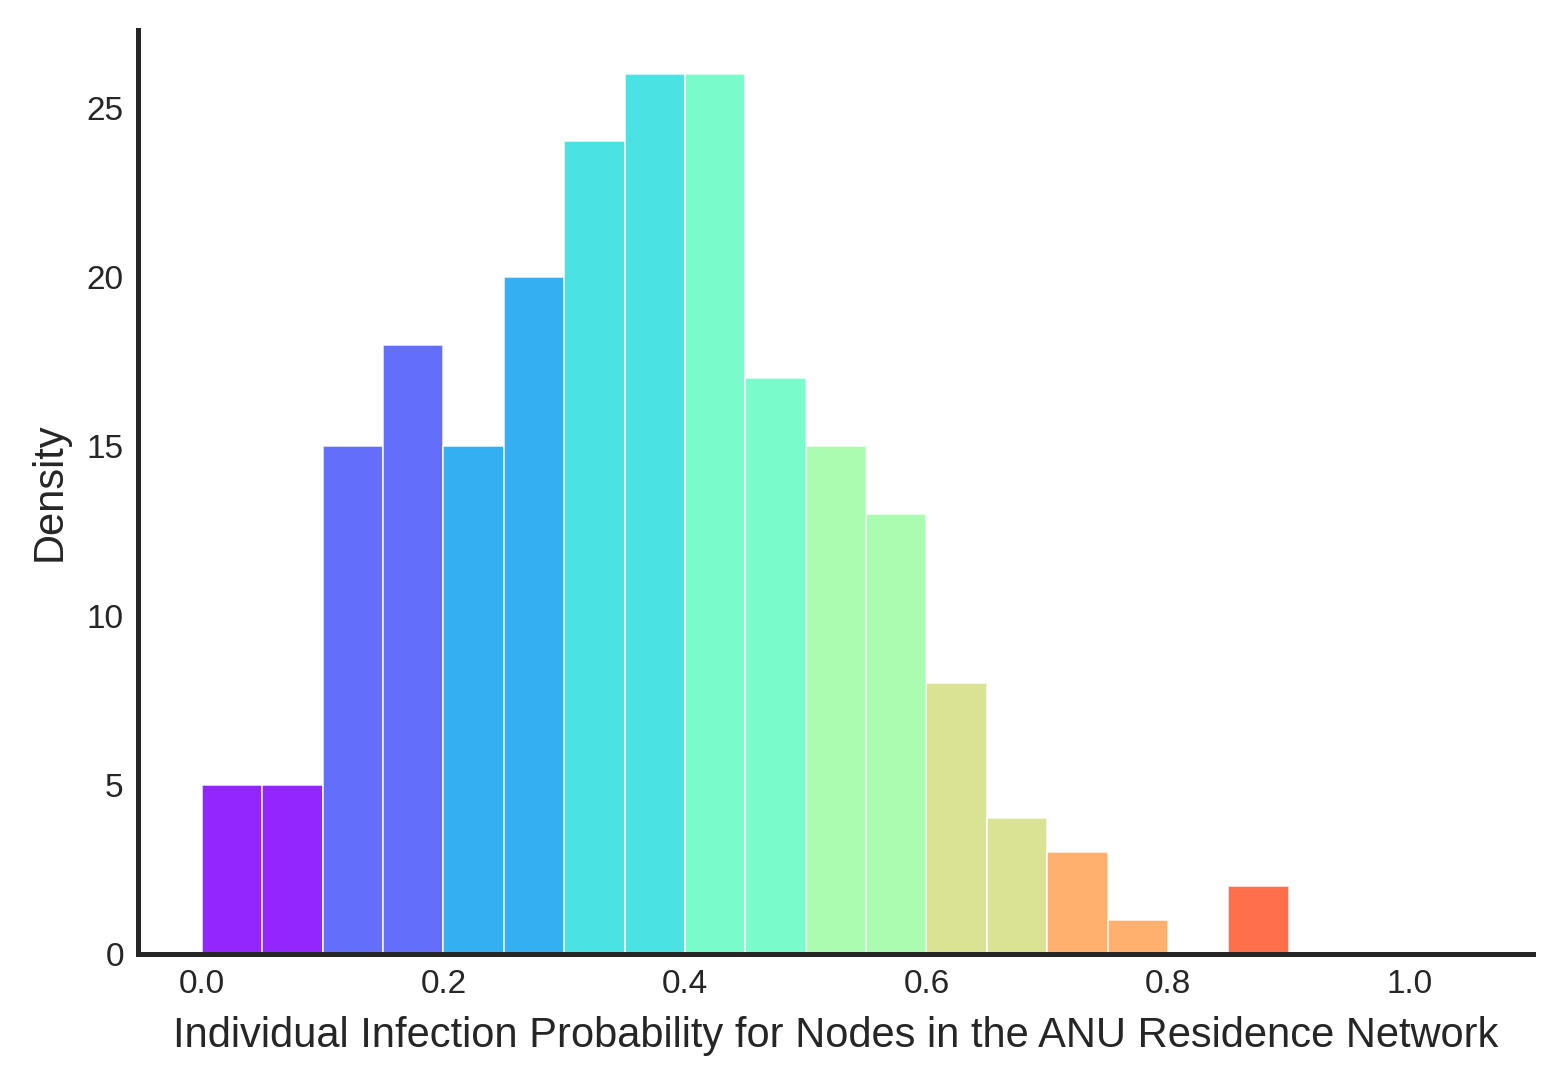

In [ ]:
vals = df_ranked["AverageAttackRate"].values
vals = vals[~np.isnan(vals)]
plt.style.use("seaborn-v0_8-white")
main_bins = np.arange(0, 1.1, 0.1)
hist_bins = np.arange(0, 1.05 + 0.001, 0.05)
colors = plt.cm.rainbow(np.linspace(0, 1, len(main_bins)-1))
plt.figure(figsize=(6, 4), dpi=300)
for i in range(len(main_bins)-1):
    lo, hi = main_bins[i], main_bins[i+1]
    mask = (vals >= lo) & (vals < hi)
    plt.hist(
        vals[mask],
        bins=hist_bins,
        alpha=0.85,
        color=colors[i],
        edgecolor="white",
        linewidth=0.4
    )
plt.xlabel("Individual Infection Probability for Nodes in the ANU Residence Network", fontsize=10)
plt.ylabel("Density", fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_linewidth(1.2)
ax.spines["bottom"].set_linewidth(1.2)
plt.savefig("/content/drive/My Drive/Individual_Attack_Rate/0213_217_residence_histogram.pdf", bbox_inches="tight")
plt.show()